## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [2]:
data = pd.read_csv( "lalonde.csv")
data['group'] = data['id'].map(lambda x : x[0:3] if(x[0:3] == 'NSW' ) else x[0:4]) 


data_NSW = data[data['treat'] == 1]
data_PSID = data[data['treat'] == 0]
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,group
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,NSW
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,NSW
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,NSW
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,NSW
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,NSW


In [3]:
data.groupby('group').mean()['re78']

group
NSW     6349.143530
PSID    6984.169742
Name: re78, dtype: float64

In [4]:
data.groupby('group').median()['re78']

group
NSW     4232.309
PSID    4975.505
Name: re78, dtype: float64

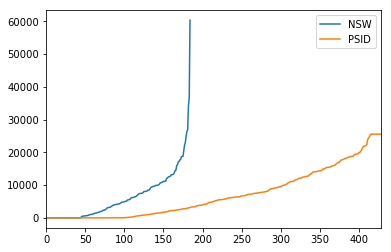

In [5]:
plt.figure(100).clear()


data_NSW_val= data_NSW['re78'].sort_values()
data_NSW_val.index = range(data_NSW_val.size)

data_PSID_val= data_PSID['re78'].sort_values()
data_PSID_val.index = range(data_PSID_val.size)


fuse_Data_re78 = pd.DataFrame(data = {'NSW':data_NSW_val , 'PSID' : data_PSID_val})
fuse_Data_re78.plot (  kind = 'line' , legend = True).figure

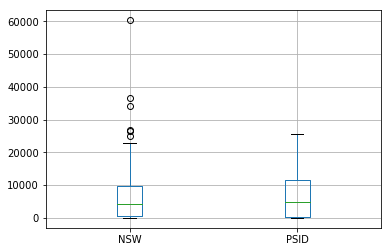

In [6]:
plt.figure(101).clear()
fuse_Data_re78.plot (  kind = 'box' , grid = True).figure

In [7]:
plt.close('all')

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.


In [8]:
data_NSW[['treat' , 'age', 'educ' , 'black' , 'hispan' , 'married' , 'nodegree', 're74' , 're75']].mean()

treat          1.000000
age           25.816216
educ          10.345946
black          0.843243
hispan         0.059459
married        0.189189
nodegree       0.708108
re74        2095.573689
re75        1532.055314
dtype: float64

In [9]:
data_PSID[['treat' , 'age', 'educ' , 'black' , 'hispan' , 'married' , 'nodegree', 're74' , 're75']].mean()

treat          0.000000
age           28.030303
educ          10.235431
black          0.202797
hispan         0.142191
married        0.512821
nodegree       0.596737
re74        5619.236506
re75        2466.484443
dtype: float64

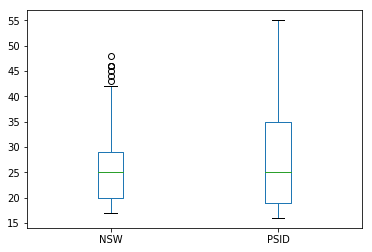

In [10]:
plt.figure(102).clear()

pd.DataFrame(data = {'NSW':data_NSW ['age'] , 'PSID' : data_PSID ['age']}).plot (  kind = 'box').figure


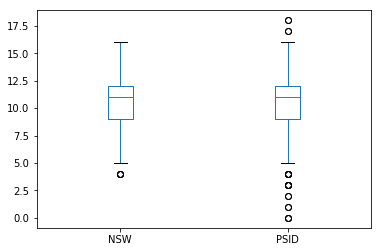

In [11]:
plt.figure(104).clear()


pd.DataFrame(data = {'NSW':data_NSW['educ'] , 'PSID' : data_PSID['educ']}).plot (  kind = 'box').figure


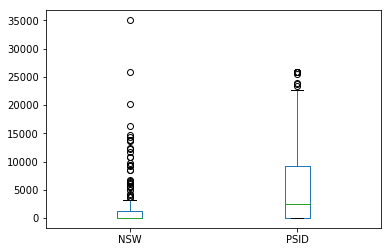

In [12]:
plt.figure(105).clear()

pd.DataFrame(data = {'NSW':data_NSW['re74'] , 'PSID' : data_PSID['re74']}).plot (  kind = 'box').figure


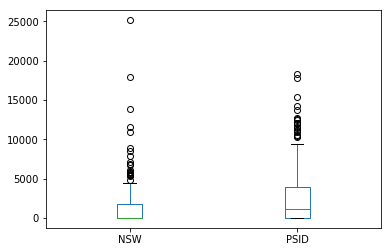

In [13]:
plt.figure(106).clear()

pd.DataFrame(data = {'NSW':data_NSW['re75'] , 'PSID' : data_PSID['re75']}).plot (  kind = 'box').figure



#### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. It's sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)


In [91]:
logistic_regressor = linear_model.LogisticRegression()

#we cast the re78 as int column because the logistic regressor cannot make a regression on continuous values 
logistic_regressor = logistic_regressor.fit(data[['treat' , 'age', 'educ' , 'black' , 'hispan' , 'married' ,\
                                                  'nodegree', 're74' , 're75']].values,\
                      data['re78'].values.astype('int'))


propensity_data = data.copy()
propensity_data ['re78reg'] = logistic_regressor.predict (data[['treat' , 'age', 'educ' , 'black' ,\
                                                             'hispan' , 'married' , 'nodegree', 're74' , 're75']]\
                                                      .values)
propensity_data.head()

48

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [87]:
propensity_data[] [(propensity_data ['re78reg'] != 0) ]

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,group,re78reg
133,NSW134,1,20,11,1,0,0,1,16318.6200,1484.9940,6943.3420,NSW,6943
165,NSW166,1,19,10,0,0,0,1,0.0000,5324.1090,13829.6200,NSW,13829
174,NSW175,1,26,10,1,0,0,1,25929.6800,6788.9580,672.8773,NSW,672
176,NSW177,1,22,12,0,1,1,0,492.2305,7055.7020,10092.8300,NSW,10092
177,NSW178,1,33,11,1,0,0,1,0.0000,7867.9160,6281.4330,NSW,6281
179,NSW180,1,29,10,0,1,0,1,0.0000,8853.6740,5112.0140,NSW,5112
181,NSW182,1,25,14,1,0,1,0,35040.0700,11536.5700,36646.9500,NSW,36646
183,NSW184,1,35,8,1,0,1,1,13732.0700,17976.1500,3786.6280,NSW,3786
184,NSW185,1,33,11,1,0,1,1,14660.7100,25142.2400,4181.9420,NSW,4181
185,PSID1,0,30,12,0,0,1,0,20166.7300,18347.2300,25564.6700,PSID,25564
